<a href="https://colab.research.google.com/github/keshsri/machine-learning/blob/main/Cats_vs_Dogs_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-06 23:30:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   149MB/s    in 0.6s    

2023-09-06 23:30:40 (149 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape = (150,150,3),
    include_top = False,
    weights = None)

pre_trained_model.load_weights(local_weights_file)

In [4]:
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


In [6]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0,2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.summary()

model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [7]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-09-06 23:30:52--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  48.0MB/s    in 1.4s    

2023-09-06 23:30:54 (48.0 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import zipfile

local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [9]:
import os

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print(len(os.listdir(train_cats_dir)))
print(len(os.listdir(validation_cats_dir)))

print(len(os.listdir(train_dogs_dir)))
print(len(os.listdir(validation_dogs_dir)))

1000
500
1000
500


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range = 40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 20,
    target_size = (150, 150),
    class_mode = 'binary'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    target_size = (150,150),
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 2)

Epoch 1/20
100/100 - 30s - loss: 0.3705 - acc: 0.8545 - val_loss: 0.0990 - val_acc: 0.9620 - 30s/epoch - 300ms/step
Epoch 2/20
100/100 - 17s - loss: 0.2058 - acc: 0.9170 - val_loss: 0.1045 - val_acc: 0.9580 - 17s/epoch - 165ms/step
Epoch 3/20
100/100 - 16s - loss: 0.1814 - acc: 0.9205 - val_loss: 0.0819 - val_acc: 0.9680 - 16s/epoch - 162ms/step
Epoch 4/20
100/100 - 15s - loss: 0.1624 - acc: 0.9340 - val_loss: 0.0876 - val_acc: 0.9640 - 15s/epoch - 154ms/step
Epoch 5/20
100/100 - 15s - loss: 0.1437 - acc: 0.9445 - val_loss: 0.0842 - val_acc: 0.9700 - 15s/epoch - 154ms/step
Epoch 6/20
100/100 - 16s - loss: 0.1391 - acc: 0.9405 - val_loss: 0.1030 - val_acc: 0.9610 - 16s/epoch - 162ms/step
Epoch 7/20
100/100 - 16s - loss: 0.1279 - acc: 0.9485 - val_loss: 0.0965 - val_acc: 0.9680 - 16s/epoch - 163ms/step
Epoch 8/20
100/100 - 16s - loss: 0.1369 - acc: 0.9445 - val_loss: 0.0955 - val_acc: 0.9670 - 16s/epoch - 156ms/step
Epoch 9/20
100/100 - 17s - loss: 0.1331 - acc: 0.9480 - val_loss: 0.0865

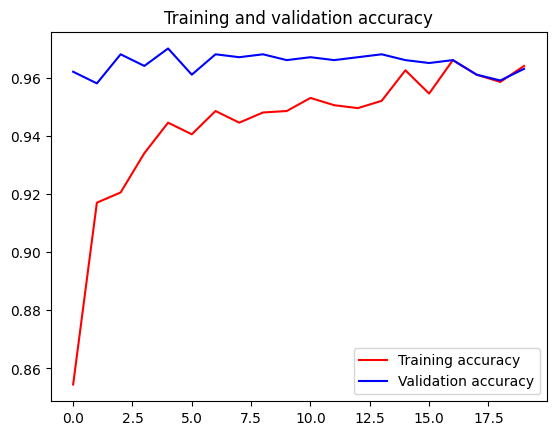

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()